In [2]:
# Install necessary libraries
!pip install pyspark wordcloud matplotlib


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from google.colab import files
import re
import unicodedata

#PySpark imports

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, expr, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA

#Start Spark Session
spark = SparkSession.builder.appName("LDA Topic Modeling").getOrCreate()


Saving UAQTEresponses.csv to UAQTEresponses (10).csv
k=2 | Log Likelihood: -11574.73 | Perplexity: 5.14
k=3 | Log Likelihood: -11730.05 | Perplexity: 5.21
k=4 | Log Likelihood: -11893.64 | Perplexity: 5.29
k=5 | Log Likelihood: -11989.84 | Perplexity: 5.33
k=6 | Log Likelihood: -12080.93 | Perplexity: 5.37
k=7 | Log Likelihood: -12225.74 | Perplexity: 5.43
k=8 | Log Likelihood: -12350.21 | Perplexity: 5.49
k=9 | Log Likelihood: -12458.91 | Perplexity: 5.54
k=10 | Log Likelihood: -12631.64 | Perplexity: 5.61


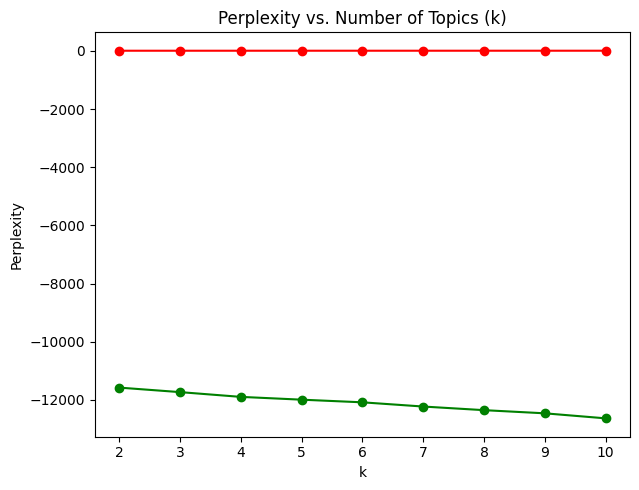


 Top Words per Topic
Topic1: good, improve, years, opened, became, thankful, experienced, doors, skills, many
Topic2: education, tuition, financial, free, help, family, helped, college, without, beneficiaries


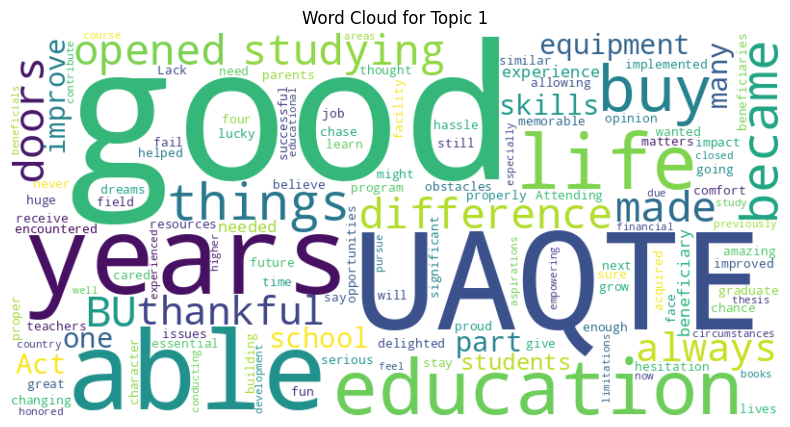

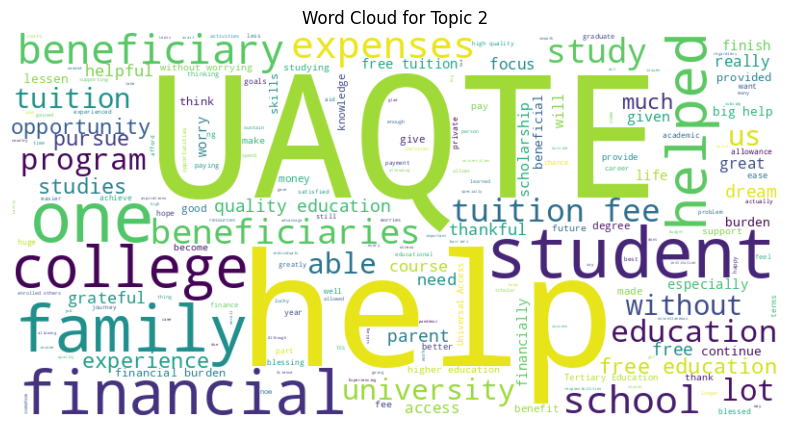

In [17]:

#Adjustable Hyperparameters

TOPIC_RANGE = range(2,11)   #Topics to try (2 to 10), Range of k values (number of topics)
MAX_ITERATIONS = 70         #Maximum number of LDA iterations
VOCAB_SIZE = 7000           #Maximum number of vocabulary words (CountVectorizer)
MIN_DF = 3                  #Maximum number of documents a word must appear in
N_TOP_WORDS = 10            #Number of words shown per topic

#Upload CSV File

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df_pandas = pd.read_csv(file_name, encoding="ISO-8859-1")
df_pandas.columns = ["text"]

#Convert Pandas to Spark DataFrame
df = spark.createDataFrame(df_pandas)

#Text Clean

df = df.withColumn("clean_text", lower(col("text")))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"http\S+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"@\w+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"#\w+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"[^\w\s]",""))

#Tokenization and Stopword Removal

tokenizer = Tokenizer(inputCol = "clean_text", outputCol = "words")

custom_stopwords = ["u", "am", "i", "in", "im", "should", "like", "one", "also",
                    "get", "use", "see", "going", "uaqte", "UAQTE"]
default_stopwords = StopWordsRemover().getStopWords()
all_stopwords = list(set(default_stopwords + custom_stopwords))

stopwords_remover = StopWordsRemover(inputCol = "words", outputCol = "filtered_words", stopWords = all_stopwords)

df = tokenizer.transform(df)
df = stopwords_remover.transform(df)
df = df.withColumn("filtered_words", expr("filter(flatten(array(filtered_words)), x -> x is not null)"))

#Vectorize Text

cv = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=VOCAB_SIZE, minDF=MIN_DF)
cv_model = cv.fit(df)
df = cv_model.transform(df)

#Train LDA with Different k

log_likelihoods = []
perflexities = []
models = []

for k in TOPIC_RANGE:
  lda = LDA(k=k, maxIter=MAX_ITERATIONS, featuresCol = "features", seed=42)
  model = lda.fit(df)
  models.append(model)
  ll = model.logLikelihood(df)
  ppl = model.logPerplexity(df)
  log_likelihoods.append(ll)
  perflexities.append(ppl)
  print(f"k={k} | Log Likelihood: {ll:.2f} | Perplexity: {ppl:.2f}")

#Plot Log Likelihood and Perplexity

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(TOPIC_RANGE, log_likelihoods, marker='o', color='green')
plt.title("Log Likelihood vs. Number of Topics (k)")
plt.ylabel("Log Likelihood")
plt.xlabel("k")

plt.subplot(1, 2, 2)
plt.plot(TOPIC_RANGE, perflexities, marker='o', color='red')
plt.title("Perplexity vs. Number of Topics (k)")
plt.ylabel("Perplexity")
plt.xlabel("k")

plt.tight_layout()
plt.show()

#Choose Best K (maximum log likelihood)

best_k = list(TOPIC_RANGE)[np.argmin(perflexities)]
best_model = models[np.argmin(perflexities)]

#Extract Top Words per TOPIC_RANGE

vocab = cv_model.vocabulary
topics = best_model.describeTopics(maxTermsPerTopic=N_TOP_WORDS)
topics_words = topics.rdd\
  .map(lambda row:[vocab[idx] for idx in row['termIndices']])\
  .collect()

print("\n Top Words per Topic")
for i, words in enumerate(topics_words):
  print(f"Topic{i+1}: {', '.join(words)}")

#Predict Topic for Each Document

transformed = best_model.transform(df)
transformed = transformed.select("text", "topicDistribution")

#Convert topicDisrtribution to Pandas to determine main topic
def get_top_topic(dist):
  return int(np.argmax(dist))

topic_assignments = transformed.rdd\
  .map(lambda row: (row['text'], get_top_topic(row['topicDistribution'])))\
  .toDF(["text", "topic"])

#Generate Word Clouds per Topic

topic_assignments_df = topic_assignments.toPandas()

for topic_id in range(best_k):
  topic_text = topic_assignments_df[topic_assignments_df['topic'] == topic_id]['text'].str.cat(sep=' ')
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Topic {topic_id + 1}')
  plt.show()

Saving UAQTEresponses.csv to UAQTEresponses (12).csv
k=2 | Log Likelihood: -11559.38 | Perplexity: 5.14
k=3 | Log Likelihood: -11696.24 | Perplexity: 5.20
k=4 | Log Likelihood: -11830.90 | Perplexity: 5.26
k=5 | Log Likelihood: -11899.22 | Perplexity: 5.29
k=6 | Log Likelihood: -11949.09 | Perplexity: 5.31
k=7 | Log Likelihood: -12044.13 | Perplexity: 5.35
k=8 | Log Likelihood: -12116.91 | Perplexity: 5.39
k=9 | Log Likelihood: -12171.21 | Perplexity: 5.41
k=10 | Log Likelihood: -12277.96 | Perplexity: 5.46


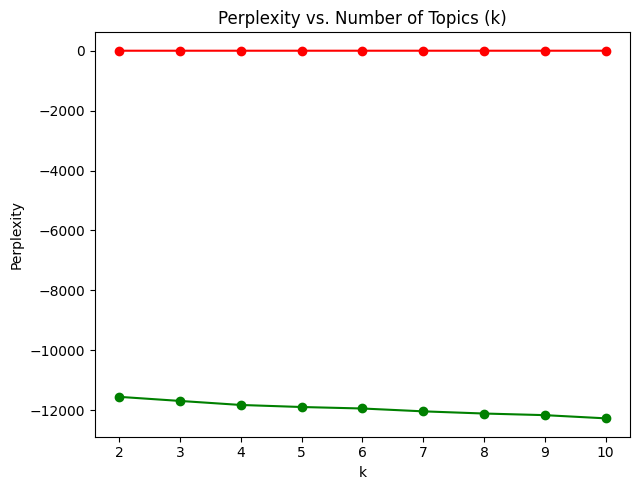


 Top Words per Topic
Topic1: good, part, became, many, improve, experienced, things, years, thankful, needed
Topic2: education, tuition, financial, free, help, family, college, helped, without, students


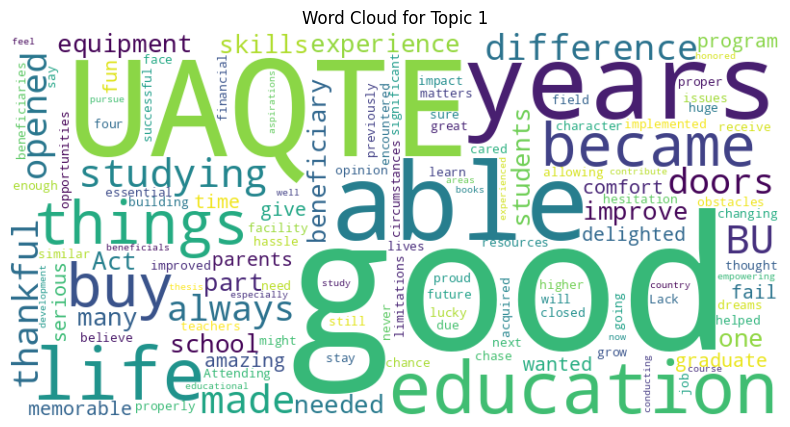

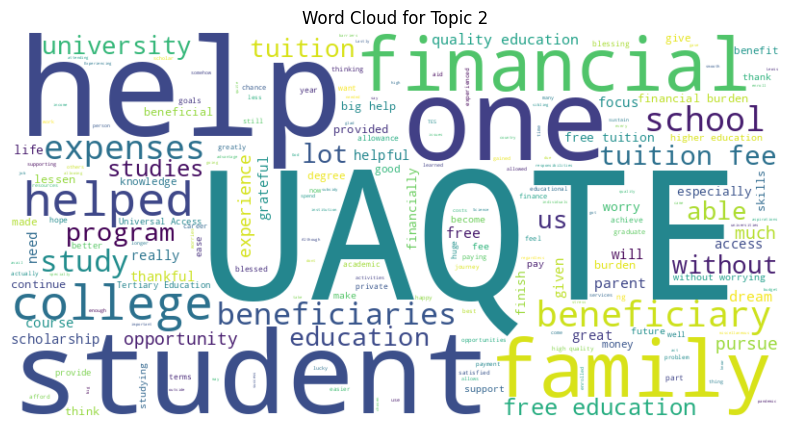

In [19]:

#Adjustable Hyperparameters

TOPIC_RANGE = range(2,11)   #Topics to try (2 to 10), Range of k values (number of topics)
MAX_ITERATIONS = 100         #Maximum number of LDA iterations
VOCAB_SIZE = 10000           #Maximum number of vocabulary words (CountVectorizer)
MIN_DF = 3                  #Maximum number of documents a word must appear in
N_TOP_WORDS = 10            #Number of words shown per topic

#Upload CSV File

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df_pandas = pd.read_csv(file_name, encoding="ISO-8859-1")
df_pandas.columns = ["text"]

#Convert Pandas to Spark DataFrame
df = spark.createDataFrame(df_pandas)

#Text Clean

df = df.withColumn("clean_text", lower(col("text")))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"http\S+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"@\w+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"#\w+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"[^\w\s]",""))

#Tokenization and Stopword Removal

tokenizer = Tokenizer(inputCol = "clean_text", outputCol = "words")

custom_stopwords = ["u", "am", "i", "in", "im", "should", "like", "one", "also",
                    "get", "use", "see", "going", "uaqte"]
default_stopwords = StopWordsRemover().getStopWords()
all_stopwords = list(set(default_stopwords + custom_stopwords))

stopwords_remover = StopWordsRemover(inputCol = "words", outputCol = "filtered_words", stopWords = all_stopwords)

df = tokenizer.transform(df)
df = stopwords_remover.transform(df)
df = df.withColumn("filtered_words", expr("filter(flatten(array(filtered_words)), x -> x is not null)"))

#Vectorize Text

cv = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=VOCAB_SIZE, minDF=MIN_DF)
cv_model = cv.fit(df)
df = cv_model.transform(df)

#Train LDA with Different k

log_likelihoods = []
perflexities = []
models = []

for k in TOPIC_RANGE:
  lda = LDA(k=k, maxIter=MAX_ITERATIONS, featuresCol = "features", seed=42)
  model = lda.fit(df)
  models.append(model)
  ll = model.logLikelihood(df)
  ppl = model.logPerplexity(df)
  log_likelihoods.append(ll)
  perflexities.append(ppl)
  print(f"k={k} | Log Likelihood: {ll:.2f} | Perplexity: {ppl:.2f}")

#Plot Log Likelihood and Perplexity

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(TOPIC_RANGE, log_likelihoods, marker='o', color='green')
plt.title("Log Likelihood vs. Number of Topics (k)")
plt.ylabel("Log Likelihood")
plt.xlabel("k")

plt.subplot(1, 2, 2)
plt.plot(TOPIC_RANGE, perflexities, marker='o', color='red')
plt.title("Perplexity vs. Number of Topics (k)")
plt.ylabel("Perplexity")
plt.xlabel("k")

plt.tight_layout()
plt.show()

#Choose Best K (maximum log likelihood)

best_k = list(TOPIC_RANGE)[np.argmin(perflexities)]
best_model = models[np.argmin(perflexities)]

#Extract Top Words per TOPIC_RANGE

vocab = cv_model.vocabulary
topics = best_model.describeTopics(maxTermsPerTopic=N_TOP_WORDS)
topics_words = topics.rdd\
  .map(lambda row:[vocab[idx] for idx in row['termIndices']])\
  .collect()

print("\n Top Words per Topic")
for i, words in enumerate(topics_words):
  print(f"Topic{i+1}: {', '.join(words)}")

#Predict Topic for Each Document

transformed = best_model.transform(df)
transformed = transformed.select("text", "topicDistribution")

#Convert topicDisrtribution to Pandas to determine main topic
def get_top_topic(dist):
  return int(np.argmax(dist))

topic_assignments = transformed.rdd\
  .map(lambda row: (row['text'], get_top_topic(row['topicDistribution'])))\
  .toDF(["text", "topic"])

#Generate Word Clouds per Topic

topic_assignments_df = topic_assignments.toPandas()

for topic_id in range(best_k):
  topic_text = topic_assignments_df[topic_assignments_df['topic'] == topic_id]['text'].str.cat(sep=' ')
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Topic {topic_id + 1}')
  plt.show()

Saving UAQTEresponses.csv to UAQTEresponses (13).csv
k=2 | Log Likelihood: -9026.59 | Perplexity: 4.71
k=3 | Log Likelihood: -9089.48 | Perplexity: 4.74
k=4 | Log Likelihood: -9162.69 | Perplexity: 4.78
k=5 | Log Likelihood: -9312.12 | Perplexity: 4.86
k=6 | Log Likelihood: -9397.00 | Perplexity: 4.90
k=7 | Log Likelihood: -9495.44 | Perplexity: 4.95
k=8 | Log Likelihood: -9576.66 | Perplexity: 4.99
k=9 | Log Likelihood: -9669.47 | Perplexity: 5.04
k=10 | Log Likelihood: -9780.27 | Perplexity: 5.10


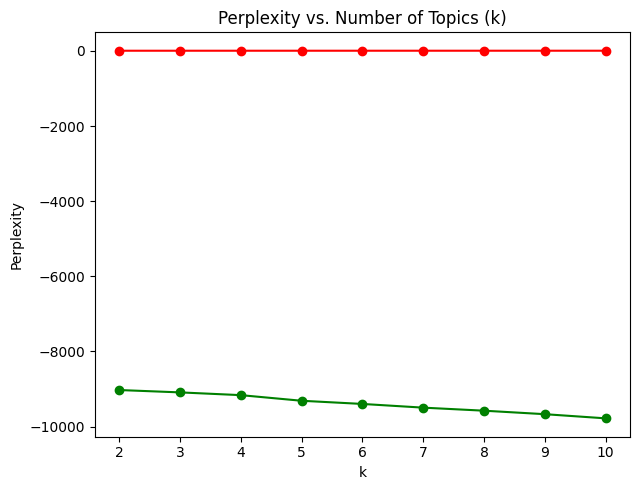


 Top Words per Topic
Topic1: education, tuition, free, help, financial, family, college, helped, expenses, school
Topic2: beneficiaries, program, opportunity, helps, students, pursue, financial, thankful, grateful, helpful


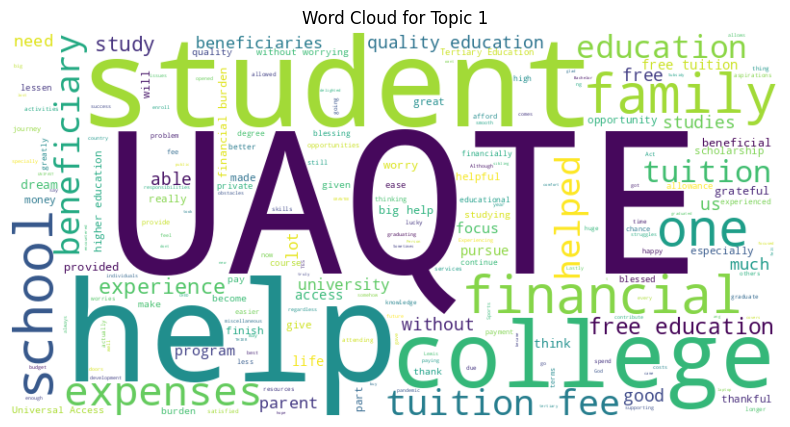

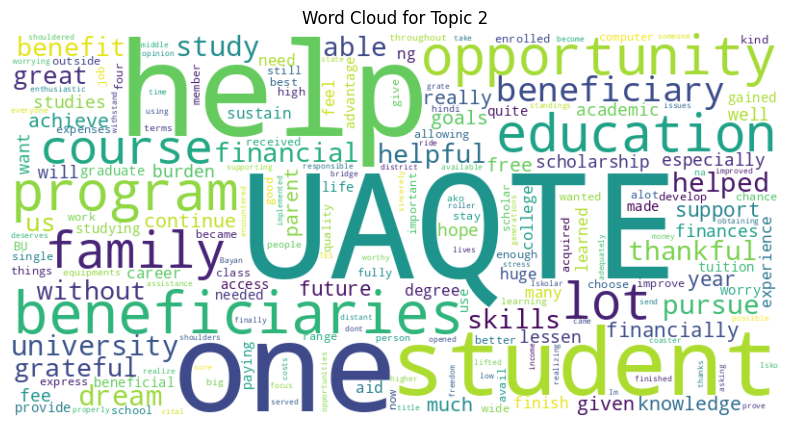

In [20]:

#Adjustable Hyperparameters

TOPIC_RANGE = range(2,11)   #Topics to try (2 to 10), Range of k values (number of topics)
MAX_ITERATIONS = 70         #Maximum number of LDA iterations
VOCAB_SIZE = 12000           #Maximum number of vocabulary words (CountVectorizer)
MIN_DF = 5                  #Maximum number of documents a word must appear in
N_TOP_WORDS = 10            #Number of words shown per topic

#Upload CSV File

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df_pandas = pd.read_csv(file_name, encoding="ISO-8859-1")
df_pandas.columns = ["text"]

#Convert Pandas to Spark DataFrame
df = spark.createDataFrame(df_pandas)

#Text Clean

df = df.withColumn("clean_text", lower(col("text")))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"http\S+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"@\w+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"#\w+",""))
df = df.withColumn("clean_text", regexp_replace(col("clean_text"), r"[^\w\s]",""))

#Tokenization and Stopword Removal

tokenizer = Tokenizer(inputCol = "clean_text", outputCol = "words")

custom_stopwords = ["u", "am", "i", "in", "im", "should", "like", "one", "also",
                    "get", "use", "see", "going", "uaqte"]
default_stopwords = StopWordsRemover().getStopWords()
all_stopwords = list(set(default_stopwords + custom_stopwords))

stopwords_remover = StopWordsRemover(inputCol = "words", outputCol = "filtered_words", stopWords = all_stopwords)

df = tokenizer.transform(df)
df = stopwords_remover.transform(df)
df = df.withColumn("filtered_words", expr("filter(flatten(array(filtered_words)), x -> x is not null)"))

#Vectorize Text

cv = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=VOCAB_SIZE, minDF=MIN_DF)
cv_model = cv.fit(df)
df = cv_model.transform(df)

#Train LDA with Different k

log_likelihoods = []
perflexities = []
models = []

for k in TOPIC_RANGE:
  lda = LDA(k=k, maxIter=MAX_ITERATIONS, featuresCol = "features", seed=42)
  model = lda.fit(df)
  models.append(model)
  ll = model.logLikelihood(df)
  ppl = model.logPerplexity(df)
  log_likelihoods.append(ll)
  perflexities.append(ppl)
  print(f"k={k} | Log Likelihood: {ll:.2f} | Perplexity: {ppl:.2f}")

#Plot Log Likelihood and Perplexity

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(TOPIC_RANGE, log_likelihoods, marker='o', color='green')
plt.title("Log Likelihood vs. Number of Topics (k)")
plt.ylabel("Log Likelihood")
plt.xlabel("k")

plt.subplot(1, 2, 2)
plt.plot(TOPIC_RANGE, perflexities, marker='o', color='red')
plt.title("Perplexity vs. Number of Topics (k)")
plt.ylabel("Perplexity")
plt.xlabel("k")

plt.tight_layout()
plt.show()

#Choose Best K (maximum log likelihood)

best_k = list(TOPIC_RANGE)[np.argmin(perflexities)]
best_model = models[np.argmin(perflexities)]

#Extract Top Words per TOPIC_RANGE

vocab = cv_model.vocabulary
topics = best_model.describeTopics(maxTermsPerTopic=N_TOP_WORDS)
topics_words = topics.rdd\
  .map(lambda row:[vocab[idx] for idx in row['termIndices']])\
  .collect()

print("\n Top Words per Topic")
for i, words in enumerate(topics_words):
  print(f"Topic{i+1}: {', '.join(words)}")

#Predict Topic for Each Document

transformed = best_model.transform(df)
transformed = transformed.select("text", "topicDistribution")

#Convert topicDisrtribution to Pandas to determine main topic
def get_top_topic(dist):
  return int(np.argmax(dist))

topic_assignments = transformed.rdd\
  .map(lambda row: (row['text'], get_top_topic(row['topicDistribution'])))\
  .toDF(["text", "topic"])

#Generate Word Clouds per Topic

topic_assignments_df = topic_assignments.toPandas()

for topic_id in range(best_k):
  topic_text = topic_assignments_df[topic_assignments_df['topic'] == topic_id]['text'].str.cat(sep=' ')
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Topic {topic_id + 1}')
  plt.show()